# Notes on Filtering and Square-law detector

This notebook has a few examples and generates some graphs used in the thesis in Chapter 4

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy
import numpy as np
import scipy.io as sio
import matplotlib.image as mpimg
from scipy import signal
import savitzky_golay

##Square-law detector
A square-law detector can look at a noisy signal with a mean value of zero, and read the peak values to get a total power of that signal.  Here we will generate a noisy signal (white noise) signal and then look at the peak values and trace them.  Then we will build a square-law detector which is x^2 to detect the total power and filter it with a low pass filter to smooth the signal out.  Finally we will compare the various graphs created.

Let's begin by defining some useful functions
# Defines

In [3]:
#IIR Single Pole Filter
def iirsp(a0,b1,x):
    y = np.empty(len(x))
    #y[n] = a0*input+b1*y[n-1]
    for i in range(2,len(x)):
        y[i]=a0*x[i]+b1*y[i-1]
    return y


#Plot step and impulse response
def impz(b,a=1):
    l = len(b)
    impulse = repeat(0.,l); impulse[0] =1.
    x = arange(0,l)
    response = lfilter(b,a,impulse1)
    #subplot(2,2,1)
    #plt.plot(impulse)
    #axis([-.5, 65, -.5, 1.1])
    subplot(2,2,1)
    stem(x, response,markerfmt='bs')
    ylabel('Amplitude')
    xlabel(r'n (samples)')
    title(r'Discrete Impulse response')
    #axis([-.5, 65, -.5, 1.1])
    subplot(2,2,2)
    plt.plot(x, response,'b-')
    ylabel('Amplitude')
    xlabel(r'Time')
    title(r'Analog Impulse response')
    subplot(2,2,3)
    step = cumsum(response)
    stem(x, step,markerfmt='bs')
    ylabel('Amplitude')
    xlabel(r'n (samples)')
    title(r'Discrete Step response')
    subplot(2,2,4)
    step = cumsum(response)
    plt.plot(x, step,'b-')
    ylabel('Amplitude')
    xlabel(r'Time')
    title(r'Analog Step response')
    #subplots_adjust(hspace=0.5)

# Generate Noisy Signal

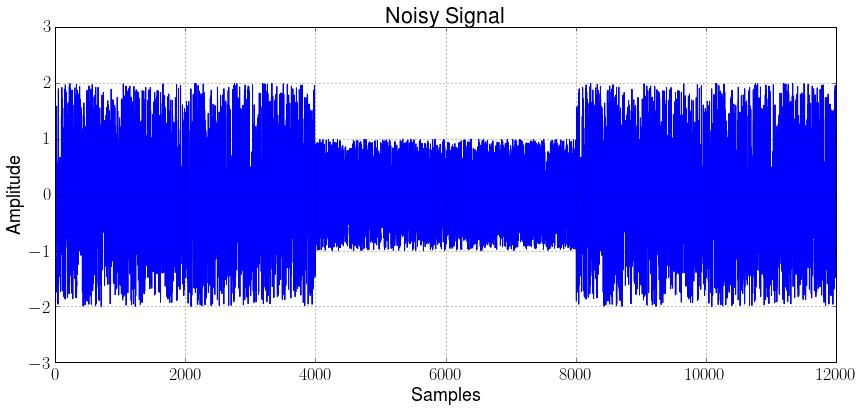

In [4]:
#Generate a noisy signal
NOISE_AMPLITUDE = 4.0
PERIOD = 200
PRESENCE_PROBABILITY = .4
# size of sample
S_O_S = 4000

signal = np.where(np.arange(4000) % PERIOD > PERIOD / 2, 0.5, -0.5)
noise = np.random.uniform(
    low=-0.5*NOISE_AMPLITUDE, 
    high=0.5*NOISE_AMPLITUDE, 
    size=S_O_S
)

#The noisy signal with a higher amplitude
noise = np.where(
    np.random.uniform(size=len(noise)) < PRESENCE_PROBABILITY, 
    signal, noise
)
#The noisy signal with a lower amplitude
noise1 = np.random.uniform(
    low=-0.25*NOISE_AMPLITUDE, 
    high=0.25*NOISE_AMPLITUDE, 
    size=S_O_S
)

#Now we combine the two signals 
noisy1 = np.append(noise,noise1);
noisy = np.append(noisy1,noise);

matplotlib.rcParams.update({'font.size': 18, 'text.usetex': True})


fig = plt.figure(figsize=(14,6), dpi=300)
plt.plot( noisy,'b-', label="signal mixed in random noise")

xlabel('Samples')
ylabel('Amplitude')
title('Noisy Signal')
axis([0, 12000, -3, 3])
grid(True)

fig.savefig("noisy_sig.pdf", dpi=300)
fig.savefig("noisy_sig.png", dpi=300)

#Peak Detection

Now we let's draw a line on where the peak values should be.  Since we defined this in the noise generator we expect the absolute value of the peaks at 2 from 0 to 4000 samples, 1 for 4000 to 8000 samples and back to 2 from 8000 to 12000 samples.  

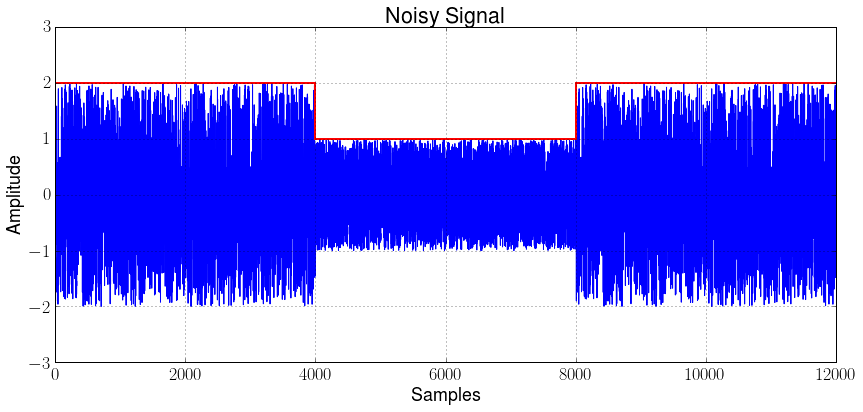

In [5]:
matplotlib.rcParams.update({'font.size': 18, 'text.usetex': True})


fig = plt.figure(figsize=(14,6), dpi=300)
plt.plot( noisy,'b-', label="signal mixed in random noise")
plt.plot([0, 4000], [2, 2], color='red', linestyle='-', linewidth=2)
plt.plot([4000, 4000], [2, 1], color='red', linestyle='-', linewidth=2)
plt.plot([4000, 8000], [1, 1], color='red', linestyle='-', linewidth=2)
plt.plot([8000, 8000], [1, 2], color='red', linestyle='-', linewidth=2)
plt.plot([8000, 12000], [2, 2], color='red', linestyle='-', linewidth=2)

xlabel('Samples')
ylabel('Amplitude')
title('Noisy Signal')
axis([0, 12000, -3, 3])
grid(True)

fig.savefig("noisy_sig_line.pdf", dpi=300)
fig.savefig("noisy_sig_line.png", dpi=300)

Now we will implement the square law detector and filter this using a low pass filter.  Let's begin by building the low pass filter and looking at the response of that filter.

1450.5


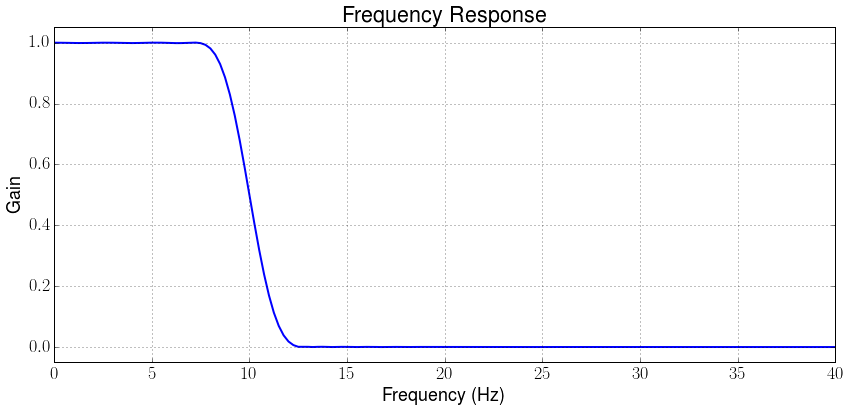

In [6]:
fig = plt.figure(figsize=(14,6), dpi=300)

from scipy.signal import kaiserord, lfilter, firwin, freqz

#First define our filter parameters
cutoff = 10.0
fs = 4000
nsamples = 12000
#t = arange(nsamples) / fs

nyq_rate = fs / 2.0
# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.  We'll design the filter
# with a 5 Hz transition width.
width = 5.0/nyq_rate 

# The desired attenuation in the stop band, in dB.
ripple_db = 60.0
 
# Compute the order and Kaiser parameter for the FIR filter.
N, beta = kaiserord(ripple_db, width)

# Use firwin with a Kaiser window to create a lowpass FIR filter.
taps = firwin(N, cutoff/nyq_rate, window=('kaiser', beta))
#b,a = signal.iirfilter(5,.3,btype='lowpass',ftype='butter')

# The phase delay of the filtered signal.
delay = (0.5 * (N-1) / fs)*fs
print delay
#b, a = signal.butter(4, 100, 'low', analog=True)
#Plot the frequency response
w, h = freqz(taps, worN=8000)
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlabel('Frequency (Hz)')
ylabel('Gain')
title('Frequency Response')
ylim(-0.05, 1.05)
xlim(0,40)
grid(True)


Now we use our square-law detector and apply the filter we created above to filter the signal.  Then graph this on our original signal.

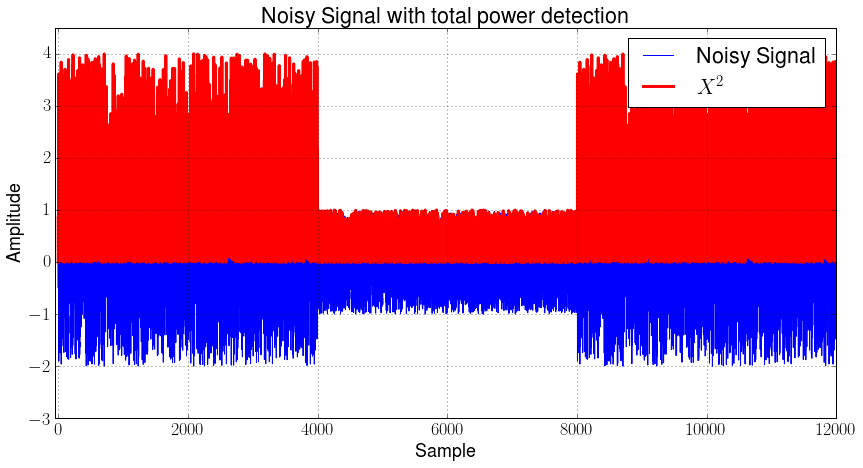

In [7]:
fig = plt.figure(figsize=(14,7), dpi=300)

#Simulating a square-law detector (X^2)
square = noisy**2

t = np.linspace(0,12000,12000)

# Plot the original signal.
plt.plot(t,noisy,label='Noisy Signal')
#plt.plot(t,square,'g-',linewidth=2)

# Plot the filtered signal, shifted to compensate for the phase delay.
#plt.plot(t,filtered_x, 'g-',label='Filtered X^2 signal',linewidth=4)
plt.plot(t,square,'r-',label='$X^2$',linewidth=3)

xlabel('Sample')
ylabel('Amplitude')
title('Noisy Signal with total power detection')
axis([-50, 12000, -3, 4.5])
grid(True)
plt.legend(loc='upper right')
fig.savefig("TPR.pdf", dpi=300)
fig.savefig("TPR.png", dpi=300)

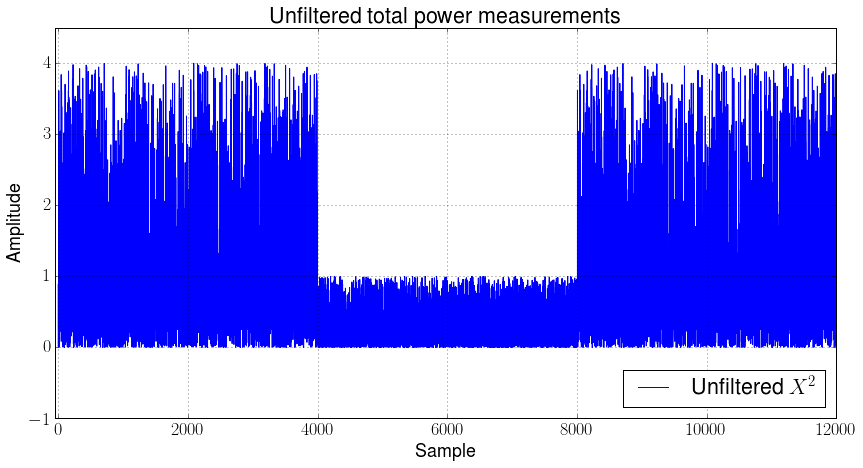

In [8]:
fig = plt.figure(figsize=(14,7), dpi=300)

#We will use a single pole IIR filter to LPF this data
#squarefilt = iirsp(.632,.368,square)
squarefilt = (iirsp(.032,.991,square))*1.1

# Use lfilter to filter x with the FIR filter.
#filtered_x = lfilter(taps, .25, square)
#plt.plot(t,noisy,label='Noisy Signal')
plt.plot(t,square,'b-',label='Unfiltered $X^2$',linewidth=1)
# Plot the filtered signal, shifted to compensate for the phase delay.
#plt.plot(t,filtered_x, 'b-',label='Filtered X^2 signal',linewidth=4)
#plt.plot(t,squarefilt,'r-',label='$X^2$ Filtered',linewidth=2)

xlabel('Sample')
ylabel('Amplitude')
title('Unfiltered total power measurements')
axis([-50, 12000, -1, 4.5])
grid(True)
plt.legend(loc='lower right')
fig.savefig("TPR_filter.pdf", dpi=300)
fig.savefig("TPR_filter.png", dpi=300)

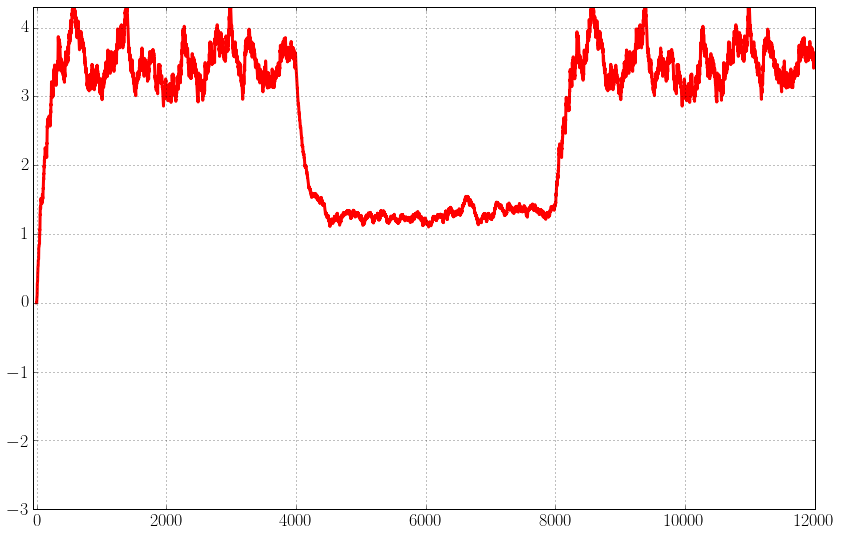

In [9]:
fig = plt.figure(figsize=(14,9), dpi=300)
plt.plot(t,squarefilt,'r-',label='$X^2$ Filter delay compensated',linewidth=3)
#plt.plot(t,noisy,label='Noisy Signal')
axis([-50, 12000, -3, 4.3])
grid(True)
fig.savefig("TPR_out.pdf", dpi=300)
fig.savefig("TPR_out.png", dpi=300)

##Impulse response
Let's now take a look at a filter response for a recursive filter IIR filter and look at both the analog and digital comparasions.  

We begin by generating the impulse function.

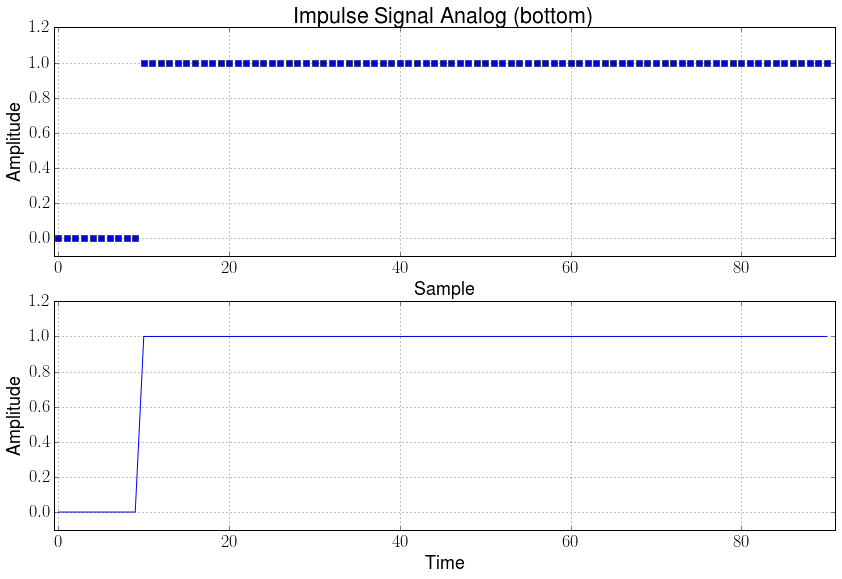

In [10]:
fig = plt.figure(figsize=(14,9), dpi=300)

x1 = np.zeros(10,dtype=np.int)
x2 = np.ones(81,dtype=np.int)
impulse1 = np.append(x1,x2);
#print impulse
plt.subplot(2, 1, 1)
plt.plot(impulse1,'bs')
xlabel('Sample')
ylabel('Amplitude')
title('Impulse Signal Analog (bottom)')
axis([-.5, 91, -.1, 1.2])
grid(True)
plt.subplot(2, 1, 2)
plt.plot(impulse1,'b-')
xlabel('Time')
ylabel('Amplitude')
axis([-.5, 91, -.1, 1.2])
grid(True)
fig.savefig("impulse.pdf", dpi=300)
fig.savefig("impulse.png", dpi=300)

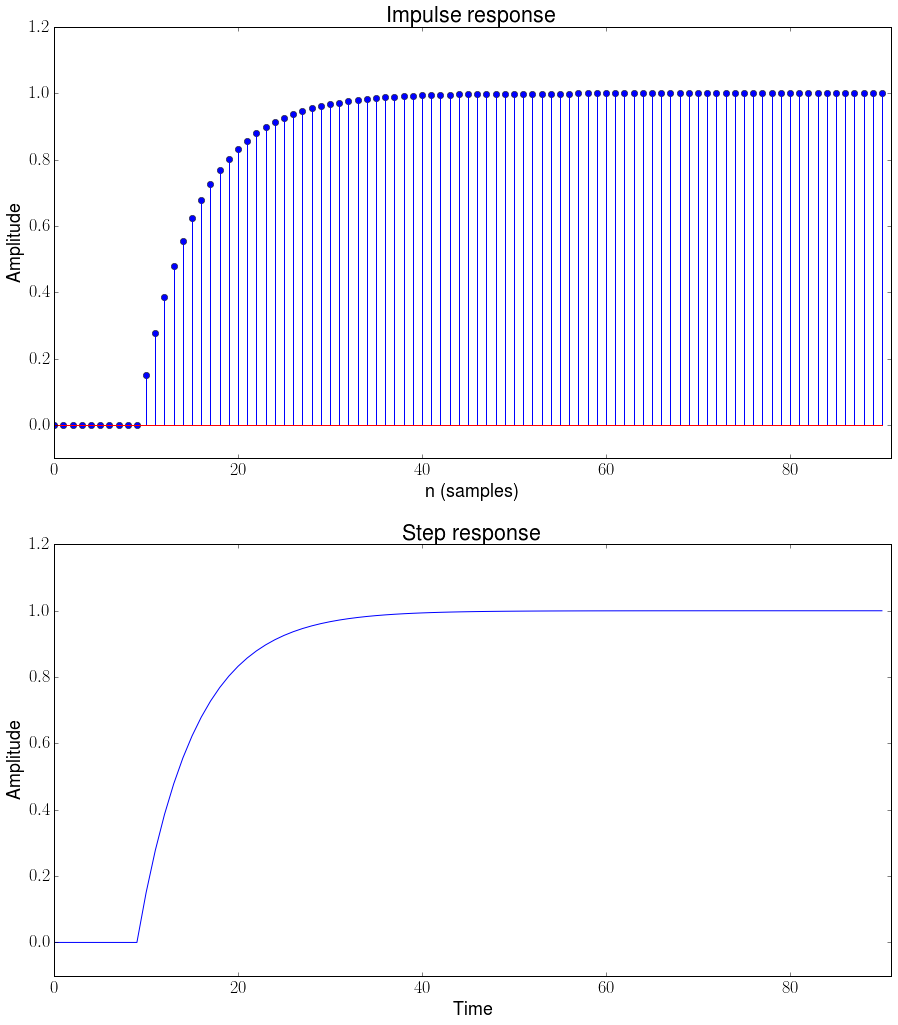

In [11]:
fig = plt.figure(figsize=(15,17), dpi=300)

#Coefficients for a single pole IIR LPF
#a0 = .15
#b1 = .85

res = iirsp(.15,.85,impulse1)
   
subplot(211)
stem(res)
ylabel('Amplitude')
xlabel(r'n (samples)')
title(r'Impulse response')
axis([0, 91, -.1, 1.2])
subplot(212)
plt.plot(res)
ylabel('Amplitude')
xlabel(r'Time')
title(r'Step response')
axis([0, 91, -.1, 1.2])

fig.savefig("response.pdf", dpi=300)
fig.savefig("response.png", dpi=300)

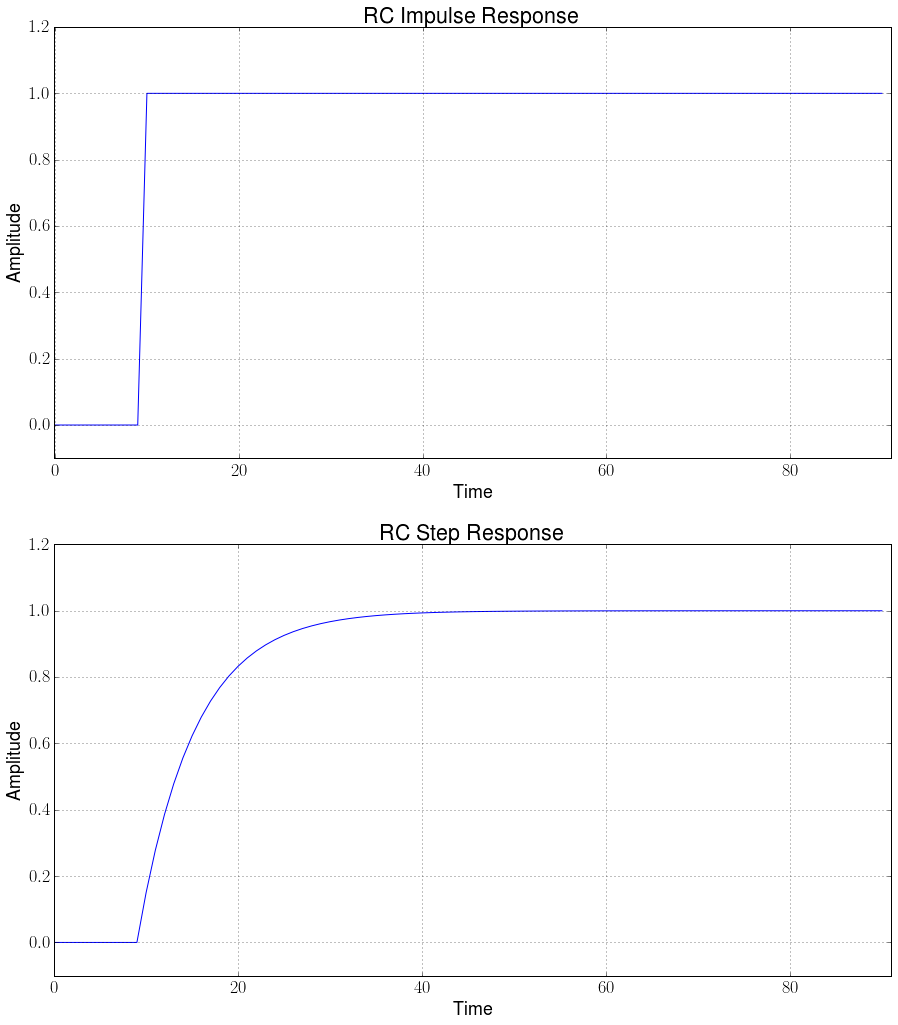

In [12]:
fig = plt.figure(figsize=(15,17), dpi=300)

plt.subplot(2, 1, 1)
plt.plot(impulse1,'b-')
xlabel('Time')
ylabel('Amplitude')
title(r'RC Impulse Response')
axis([-.1, 91, -.1, 1.2])
grid(True)
subplot(212)
plt.plot(res)
ylabel('Amplitude')
xlabel(r'Time')
title(r'RC Step Response')
grid(True)
#title(r'Step response')
axis([0, 91, -.1, 1.2])

fig.savefig("rc_response.pdf", dpi=300)
fig.savefig("rc_response.png", dpi=300)

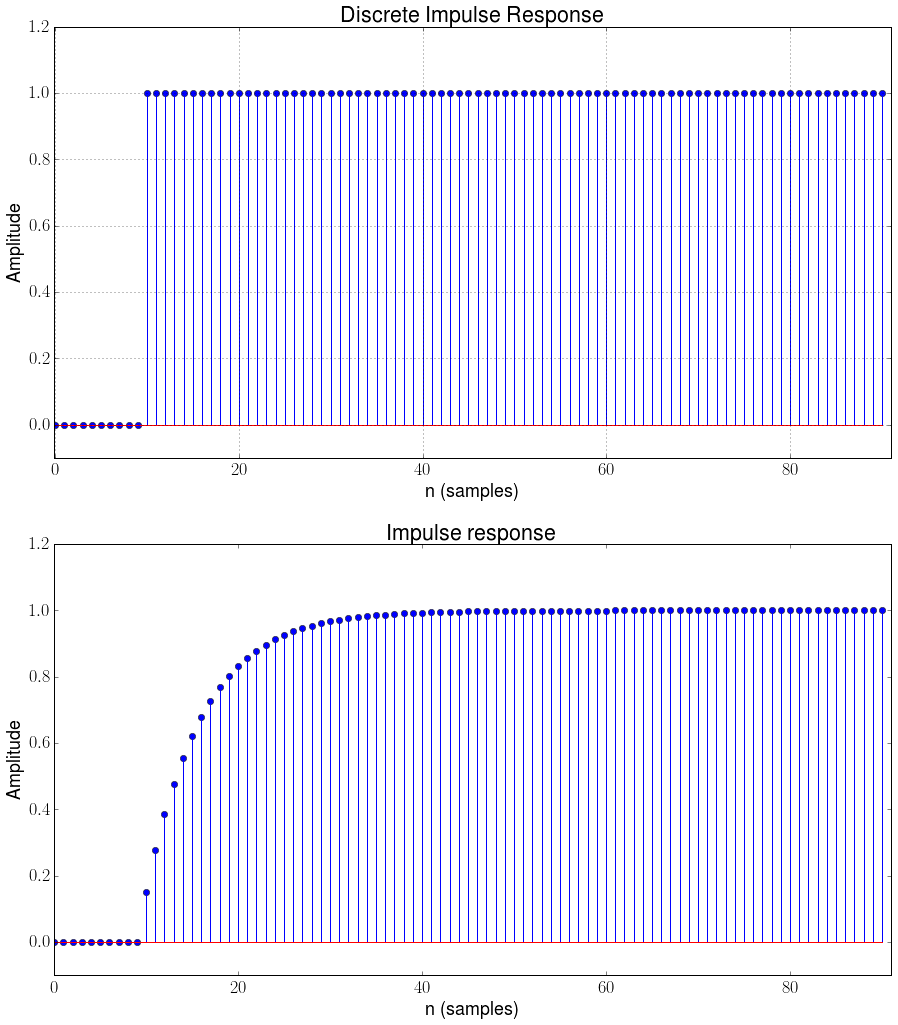

In [13]:
fig = plt.figure(figsize=(15,17), dpi=300)

plt.subplot(2, 1, 1)
stem(impulse1)
xlabel('n (samples)')
ylabel('Amplitude')
title('Discrete Impulse Response')
axis([-.1, 91, -.1, 1.2])
grid(True)
subplot(212)
stem(res)
ylabel('Amplitude')
xlabel(r'n (samples)')
title(r'Impulse response')
axis([0, 91, -.1, 1.2])

fig.savefig("iir_response.pdf", dpi=300)
fig.savefig("iir_response.png", dpi=300)

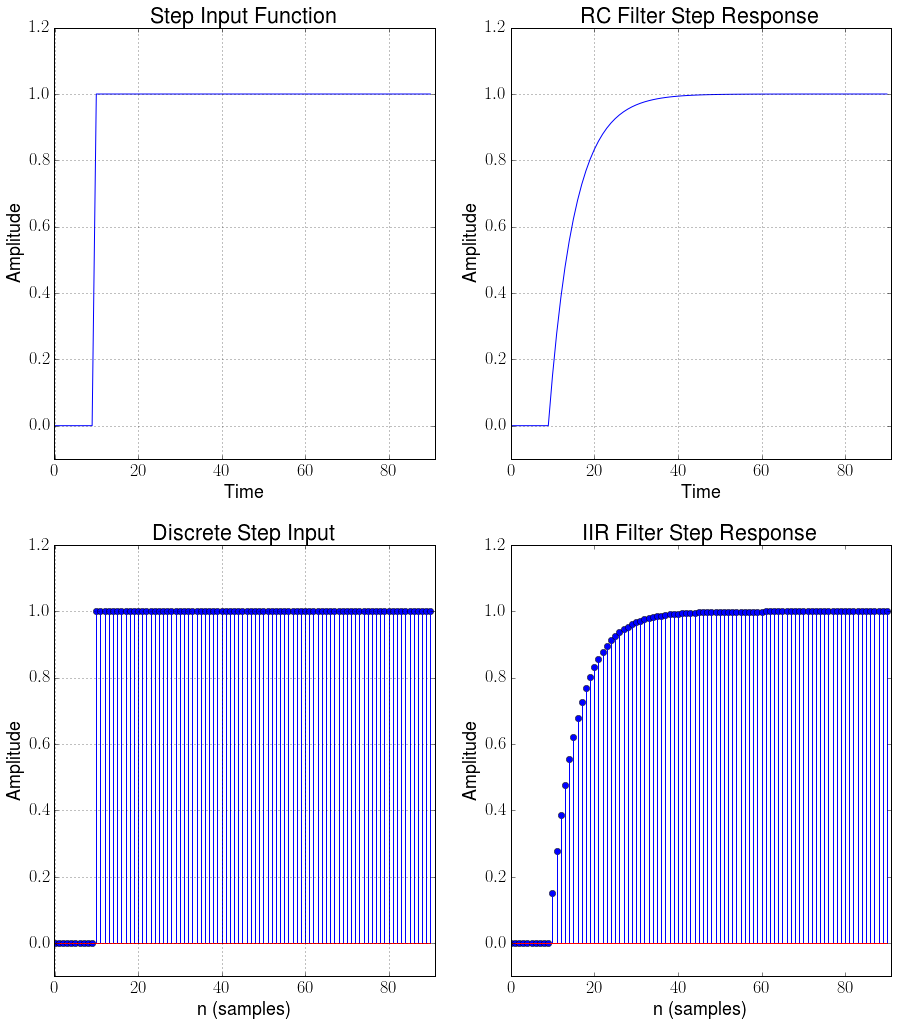

In [14]:
fig = plt.figure(figsize=(15,17), dpi=300)

plt.subplot(2, 2, 1)
plt.plot(impulse1,'b-')
xlabel('Time')
ylabel('Amplitude')
title(r'Step Input Function')
axis([-.1, 91, -.1, 1.2])
grid(True)
subplot(222)
plt.plot(res)
ylabel('Amplitude')
xlabel(r'Time')
title(r'RC Filter Step Response')
grid(True)
#title(r'Step response')
axis([0, 91, -.1, 1.2])

plt.subplot(2, 2, 3)
stem(impulse1)
xlabel('n (samples)')
ylabel('Amplitude')
title('Discrete Step Input')
axis([-.1, 91, -.1, 1.2])
grid(True)
subplot(224)
stem(res)
ylabel('Amplitude')
xlabel(r'n (samples)')
title(r'IIR Filter Step Response')
axis([0, 91, -.1, 1.2])

fig.savefig("all_four.pdf", dpi=300)
fig.savefig("all_four.png", dpi=300)